In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import re
import json
plt.rcParams['figure.figsize'] = [5, 5]  # default hor./vert. size of plots, in inches

In [2]:
# function that gets all notebooks with a given config

def get_df(bitlen, seclvl, mtalg, client_ip, server_ip, min_bandwidth, max_bandwidth, ignore_bandwidth = False):
    names = []
    dicts = process_files_in_directory('../log/', 0, 26, 50)
    for k in dicts:
        # print(f"DEBUG: extracting config from {k}")
        s = ''.join(dicts[k])[50:]
        d = json.loads(s)
        # skip logs before different bit lengths were introduced
        if 'bit_length' not in d['misc']:
            continue
        if d['client']['ip_address'] == client_ip and d['server']['ip_address'] == server_ip:
            if d['misc']['security_level'] == seclvl and d['misc']['mt_algorithm'] == mtalg and d['misc']['bit_length'] == bitlen:
                #print(f"Found file that has appropriate config: {k}")
                bandwidth = extract_bandwidth_from_log_file(f'../log/{k}')
                if ignore_bandwidth:
                    names.append(k[6:-4])
                elif bandwidth:
                    if float(bandwidth) > min_bandwidth and float(bandwidth) < max_bandwidth:
                        names.append(k[6:-4])
    files_to_remove = []
    for file_name in names:
        if not os.path.exists(f'../dfs/{file_name}.csv'):
            # File doesn't exist, add it to the list for removal
            #print(f"df for {file_name} does not exist!")
            files_to_remove.append(file_name)
    
    # Remove the files that don't exist from the original list
    for file_name in files_to_remove:
        names.remove(file_name)
    return pd.concat((pd.read_csv(f"../dfs/{df_name}.csv") for df_name in names), ignore_index=True).reset_index(drop=True)

def read_lines(file_path, start_line, end_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[start_line:end_line]
    return lines
def read_until_info(file_path):
    out = []
    with open(file_path, 'r') as file:
        x = file.readline()
        while not 'INFO'in x:
            out.append(x)
            x = file.readline()
    return out
def process_files_in_directory(directory_path, n, m, k):
    result_dict = {}

    # Iterate over files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            # Check if the file has more than N rows
            with open(file_path, 'r') as file:
                line_count = sum(1 for _ in file)

            if line_count > k:
                # Read lines n to m from the file
                lines = read_until_info(file_path)

                # Store the lines in a JSON dictionary
                result_dict[filename] = lines

    return result_dict
def remove_chars_after_last_bracket(input_string):
    last_bracket_index = input_string.rfind('}')
    
    if last_bracket_index != -1:
        return input_string[:last_bracket_index + 1]
    else:
        # If there are no closing curly brackets, return the original string
        return input_string
    
def extract_bandwidth_from_log_file(log_file_path):

    # Open the log file and iterate through its lines
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Use a regular expression to match the "Bandwidth:" string and the float value
            match = re.search(r"andwidth: (\d+\.\d+) Mbits/sec", line)
            if match:
                bandwidth_str = match.group(1)
                return(float(bandwidth_str))

    return None

def remove_results_between(df, column, a, b):
    return df[(df[column].notna()) & (df[column] > a) & (df[column] < b)] 

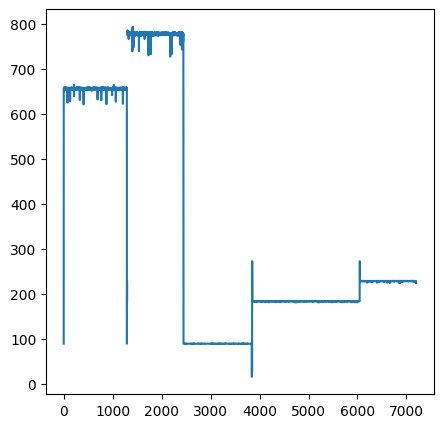

<Axes: >

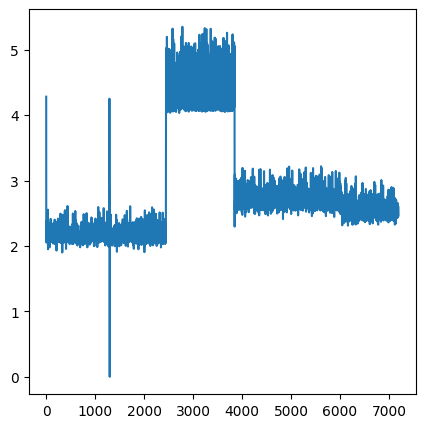

In [3]:
# exploring
df = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 0, 150, True)
# df = remove_results_between(df, 'server.hardware.throughput', 10/8, 100/8)
(df['server.hardware.throughput']*8).plot()
plt.show()
(df['server.timings.total'] / 1000).plot()

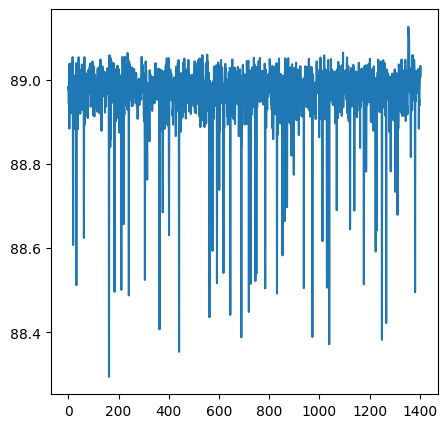

<Axes: >

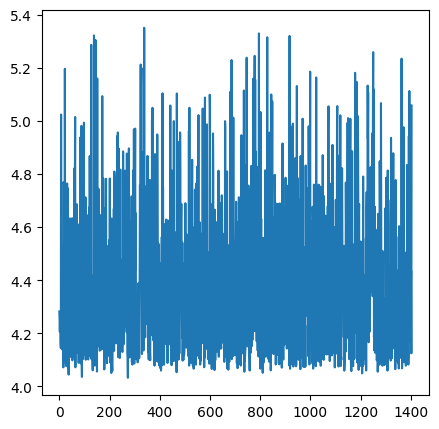

In [4]:
# 100 mbit
df_100 = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 0, 150)
df_100 = remove_results_between(df_100, 'server.hardware.throughput', 60/8, 100/8)
(df_100['server.hardware.throughput']*8).plot()
plt.show()
(df_100['server.timings.total'] / 1000).plot()

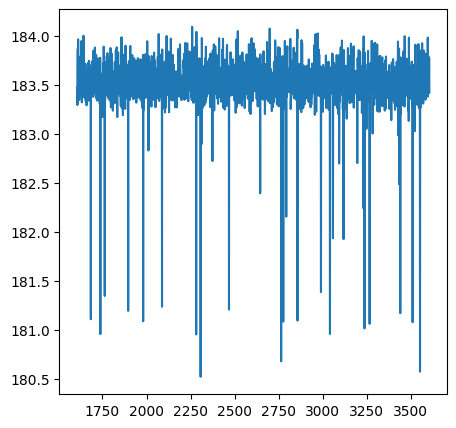

<Axes: >

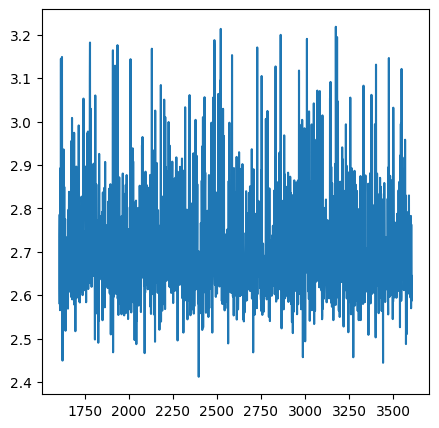

In [5]:
# 190 mbit
df_190 = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 93, 300)
df_190 = remove_results_between(df_190, 'server.hardware.throughput', 150/8, 210/8).tail(2000)
(df_190['server.hardware.throughput']*8).plot()
plt.show()
(df_190['server.timings.total'] / 1000).plot()

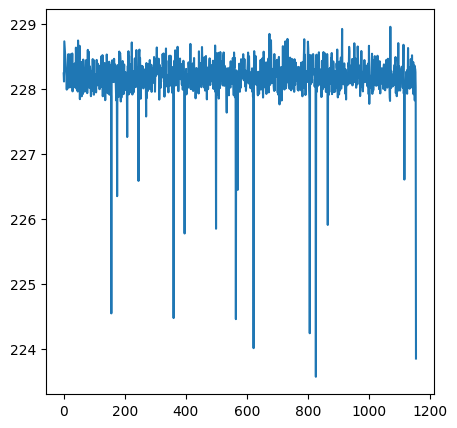

<Axes: >

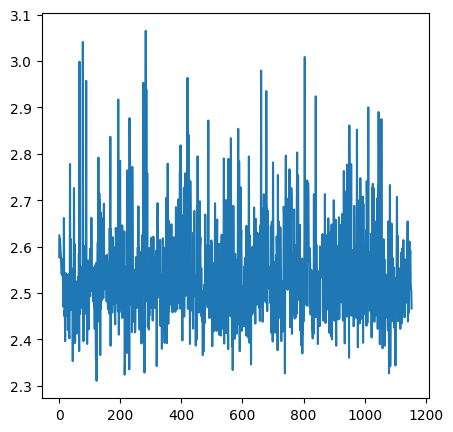

In [6]:
# 250 mbit
df_250 = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 200, 300)
df_250 = remove_results_between(df_250, 'server.hardware.throughput', 220/8, 240/8)
(df_250['server.hardware.throughput']*8).plot()
plt.show()
(df_250['server.timings.total'] / 1000).plot()

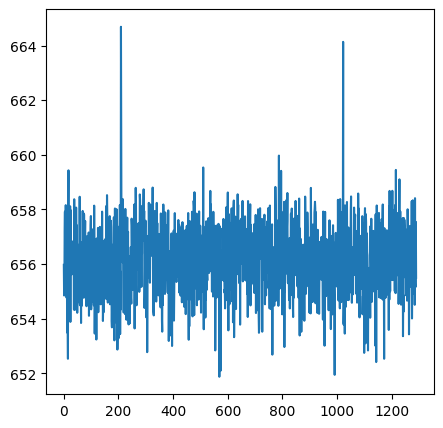

<Axes: >

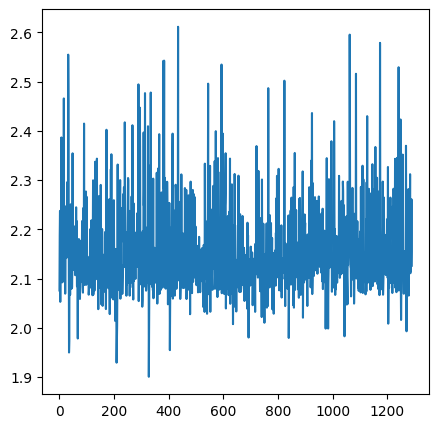

In [7]:
# 700 mbit
df_700 = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 600, 900)
df_700 = remove_results_between(df_700, 'server.hardware.throughput', 650/8, 700/8)
(df_700['server.hardware.throughput']*8).plot()
plt.show()
(df_700['server.timings.total'] / 1000).plot()

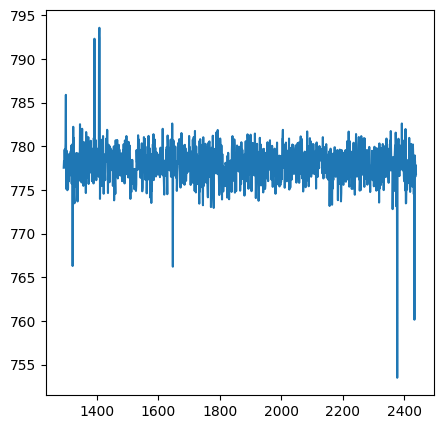

<Axes: >

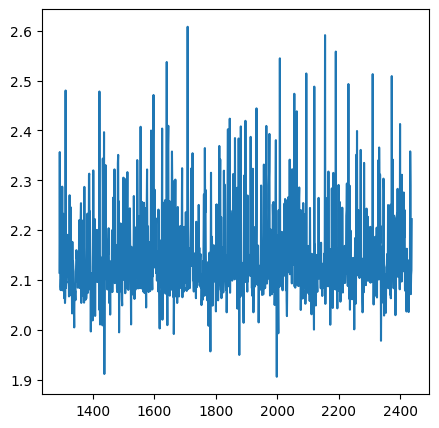

In [8]:
# 900 mbit
df_900 = get_df('32', '80', '0', '192.168.5.121', '192.168.5.122', 600, 1000)
df_900 = remove_results_between(df_900, 'server.hardware.throughput', 750/8, 800/8)
(df_900['server.hardware.throughput']*8).plot()
plt.show()
(df_900['server.timings.total'] / 1000).plot()

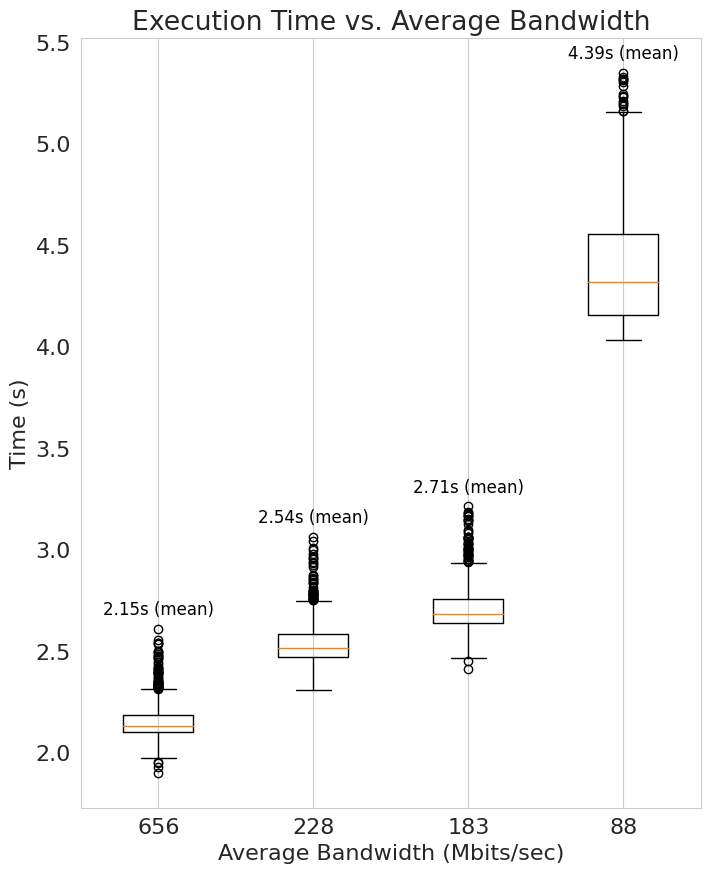

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply seaborn style
sns.set_style("whitegrid")

# Adjust font size
plt.rcParams.update({'font.size': 16})

# Define data
df_list = [df_700.head(1000), df_250.head(1000), df_190.head(1000), df_100.head(1000)]
bandwidths = [df['server.hardware.throughput'].mean() * 8 for df in df_list]
times = [df['server.timings.total'] / 1000 for df in df_list]

# Plot
fig, ax = plt.subplots(figsize=(8, 10))

# Create boxplot
boxplot = ax.boxplot(times, labels=[f"{int(b)}" for b in bandwidths])

# Set labels and title
ax.set_xlabel("Average Bandwidth (Mbits/sec)")
ax.set_ylabel("Time (s)")
ax.set_title("Execution Time vs. Average Bandwidth")

# Add mean value annotations
for i, b in enumerate(bandwidths):
    mean_val = np.mean(times[i])
    max_val = max(times[i])
    ax.text(i + 1, max_val + 0.05, f"{mean_val:.2f}s (mean)", ha='center', va='bottom', color='black', fontsize=12)


# Add gridlines
ax.grid(axis='y')

# Save plot
plt.savefig("ex1_time.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


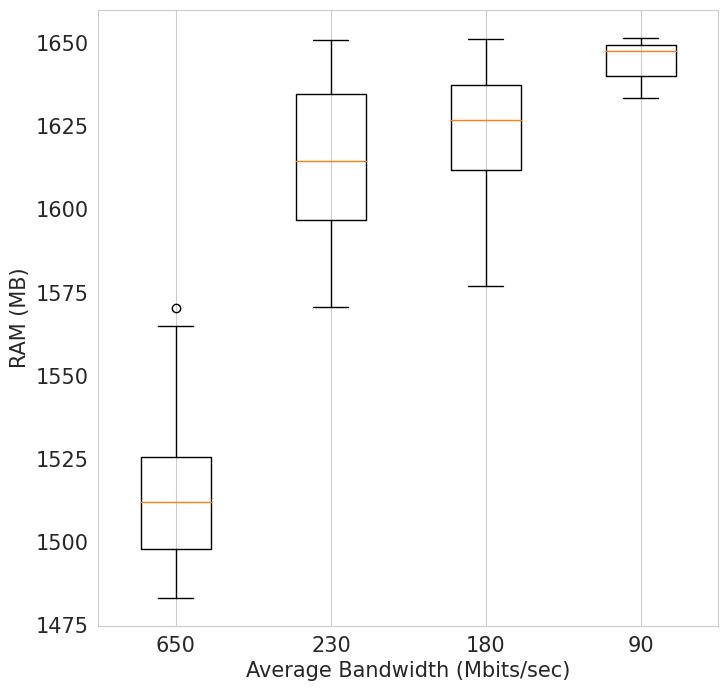

In [21]:
# plotting
plt.rcParams.update({'font.size': 15})
df_list = [df_700.head(1000), df_250.head(1000), df_190.head(1000), df_100.head(1000)]
plt.rcParams['figure.figsize'] = [8, 8]  # default hor./vert. size of plots, in inches
labels = [''] * len(df_list)
for i in range(len(df_list)):
    labels[i] += f"{df_list[i]['server.Maximum resident set size (kbytes)'].mean() * 8:.0f}"
labels = ['650', '230', '180', '90']
ax = plt.boxplot([df['server.Maximum resident set size (kbytes)'] / 100 for df in df_list], labels=labels, vert=True)
plt.xlabel("Average Bandwidth (Mbits/sec)")
plt.ylabel("RAM (MB)")
plt.grid(axis='y')
plt.savefig("ex1_ram.pdf", format="pdf", bbox_inches="tight")

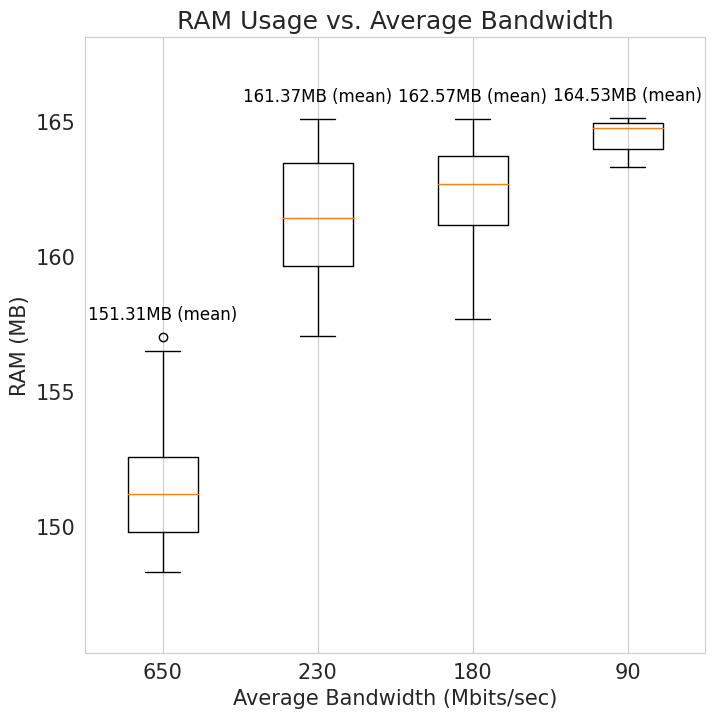

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply seaborn style
sns.set_style("whitegrid")

# Adjust font size
plt.rcParams.update({'font.size': 15})

# Define data
df_list = [df_700.head(1000), df_250.head(1000), df_190.head(1000), df_100.head(1000)]
ram_values = [df['server.Maximum resident set size (kbytes)'] / 1000 for df in df_list]

# Bandwidth labels
bandwidth_labels = ['650', '230', '180', '90']

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Create boxplot
boxplot = ax.boxplot(ram_values, vert=True, labels=bandwidth_labels)

# Set labels and title
ax.set_xlabel("Average Bandwidth (Mbits/sec)")
ax.set_ylabel("RAM (MB)")
ax.set_title("RAM Usage vs. Average Bandwidth")

# Add mean value annotations
for i, ram in enumerate(ram_values):
    mean_val = np.mean(ram)
    max_val = max(ram)
    ax.text(i + 1, max_val + 0.5, f"{mean_val:.2f}MB (mean)", ha='center', va='bottom', color='black', fontsize=12)

# Adjust y-axis range
min_val = min([min(ram) for ram in ram_values])
max_val = max([max(ram) for ram in ram_values])
plt.ylim(min_val - 3, max_val + 3)  # Extend the range by 3 units above and below

# Add gridlines
ax.grid(axis='y')

# Save plot
plt.savefig("ex1_ram.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


In [11]:
for d in df_list:
    print(f"Bandwidth: {d['server.hardware.throughput'].mean()}")
    print (f"Time: {d['server.timings.total'].mean() / 1000}")
    print (f"RAM: {d['server.Maximum resident set size (kbytes)'].mean() / 100}")

Bandwidth: 82.01469664953751
Time: 2.152735831
RAM: 1513.06132
Bandwidth: 28.521161822855102
Time: 2.53788238
RAM: 1613.69228
Bandwidth: 22.9400038215844
Time: 2.7105881199999997
RAM: 1625.6851199999999
Bandwidth: 11.120390915306599
Time: 4.392196136
RAM: 1645.2704800000001
